<a href="https://colab.research.google.com/github/letianzj/QuantResearch/blob/master/ml/dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DQN CartPole

Use deep q network to solve CartPole game.

[OpenAI Gym CartPole](https://gym.openai.com/envs/CartPole-v0/) has four states, cart position, cart speed, pole angle, and pole speed. The actions are either going left or right. The objective is to keep pole from falling. Every move that doesn't lead to a fall gets reward 1.

DQN is off policy, value based, TD method to solve control problems. In 2015, DeepMind used DQN to play 50 Atari games and was able to achieve human-level performance. It uses a DNN to model the q-value functions whose loss function is

$$
L = \left( r+\gamma \underset{a' \in A}{\max}Q(s',a') - Q(s,a) \right)^2  \tag{1}
$$

DQN adds experience replay buffer and freezing target network to improve performance.

This notebook follows closely [here](https://github.com/dragen1860/Deep-Learning-with-TensorFlow-book/blob/master/ch14-%E5%BC%BA%E5%8C%96%E5%AD%A6%E4%B9%A0/dqn_tf.py). Just added some comments for my own understanding.


[Reference]
* Sutton, Richard S., and Andrew G. Barto. Reinforcement learning: An introduction. MIT press, 2018.
* [RL by David Silver](https://www.davidsilver.uk/teaching/)
* [Lil'Log](https://lilianweng.github.io/lil-log/)
* [Deep Learning with TensorFlow](https://github.com/dragen1860/Deep-Learning-with-TensorFlow-book)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import gym
import collections
import random
import tensorflow as tf
from tensorflow import keras

In [ ]:
env = gym.make('CartPole-v1')
env.seed(1234)
tf.random.set_seed(1234)
np.random.seed(1234)

In [ ]:
# Hyperparameters
episodes = 10000
learning_rate = 0.0002
gamma = 0.99
buffer_limit = 50000
batch_size = 32

In [ ]:
class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def add_experience(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])
        # return Tensor
        return tf.constant(s_lst, dtype=tf.float32),\
                      tf.constant(a_lst, dtype=tf.int32), \
                      tf.constant(r_lst, dtype=tf.float32), \
                      tf.constant(s_prime_lst, dtype=tf.float32), \
                      tf.constant(done_mask_lst, dtype=tf.float32)

    def size(self):
        return len(self.buffer)

In [ ]:
class DQN(keras.Model):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = keras.layers.Dense(256, kernel_initializer='he_normal')
        self.fc2 = keras.layers.Dense(256, kernel_initializer='he_normal')
        self.fc3 = keras.layers.Dense(2, kernel_initializer='he_normal')

    # input s, output Q value/logit
    def call(self, x, training=None):
        x = tf.nn.relu(self.fc1(x))
        x = tf.nn.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def get_action(self, s, epsilon):
        s = tf.constant(s, dtype=tf.float32)        # to tensor
        s = tf.expand_dims(s, axis=0)               # [4] => [1,4]
        out = self(s)[0]                            # logits, shape = [1, 2]
        coin = random.random()
        # epsilon greedy
        if coin < epsilon:
            return random.randint(0, 1)
        else:  # action with max Q value
            return int(tf.argmax(out))


def train(q, q_target, memory, optimizer):
    # update Q-Net according to equation (1), keep target net constant
    huber = keras.losses.Huber()
    for i in range(10):  # train on some samples
        # sample from replay buffer
        s, a, r, s_prime, done_mask = memory.sample(batch_size)
        with tf.GradientTape() as tape:
            q_out = q(s)  # s: [b, 4] ==> [b, 2], Q(s,a)
            # pick up q-value according to indices; a: [b, 1] action, indices: [b, 1];
            indices = tf.expand_dims(tf.range(a.shape[0]), axis=1)
            indices = tf.concat([indices, a], axis=1)       # [b, 2]; for every sample in the batch, which action is selected
            q_a = tf.gather_nd(q_out, indices) # [b], Q(s, a) for actions chosen
            q_a = tf.expand_dims(q_a, axis=1) # [b]=> [b,1]
            # max Q(s',a) from target net,  [b,4]=>[b,2]=>[b,1]
            max_q_prime = tf.reduce_max(q_target(s_prime),axis=1,keepdims=True)
            # Q(s,a_t) target value based on Bellman equation
            target = r + gamma * max_q_prime * done_mask
            # Loss of equation (1)
            loss = huber(q_a, target)

        # Update Q-Net by minimizing Bellman loss
        grads = tape.gradient(loss, q.trainable_variables)
        optimizer.apply_gradients(zip(grads, q.trainable_variables))

In [ ]:
q = DQN()
q_target = DQN()
q.build(input_shape=(2,4))
q_target.build(input_shape=(2,4))
for src, dest in zip(q.variables, q_target.variables):
    dest.assign(src)     # q weights ==> q-target weights
memory = ReplayBuffer()

print_interval = 20
score = 0.0
avg_score = []
optimizer = keras.optimizers.Adam(lr=learning_rate)

for n_epi in range(episodes):
    # epsilon decay
    epsilon = max(0.01, 0.08 - 0.01 * (n_epi / 200))
    s = env.reset()       # s is initial obs after reset
    for t in range(600):  # run one episode
        a = q.get_action(s, epsilon)
        s_prime, r, done, info = env.step(a)
        done_mask = 0.0 if done else 1.0
        memory.add_experience((s, a, r / 100.0, s_prime, done_mask))
        s = s_prime
        score += r  # total return
        if done:
            break

    if memory.size() > 2000:  # train as soon as there are 2000 experiences
        train(q, q_target, memory, optimizer)

    if n_epi % print_interval == 0 and n_epi != 0:
        for src, dest in zip(q.variables, q_target.variables):
            dest.assign(src)  # Update Target Net
        # print("# of episode :{}, avg score : {:.1f}, buffer size : {}, " \
        #       "epsilon : {:.1f}%" \
        #       .format(n_epi, score / print_interval, memory.size(), epsilon * 100))
        avg_score.append(score / print_interval)
        score = 0.0
env.close()


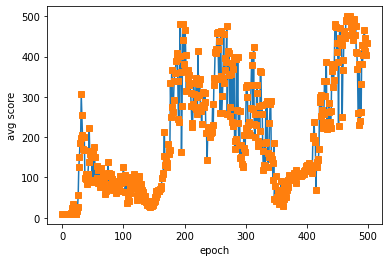

In [ ]:
plt.plot(np.arange(len(avg_score)), avg_score)
plt.plot(np.arange(len(avg_score)), avg_score, 's')
plt.xlabel('epoch')
plt.ylabel('avg score')
plt.show()